In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

In [78]:
df = pd.read_csv('C:/Users/lidi_/OneDrive/Documentos/Lidiane/MBA - DATA SCIENCE/TCC/archive/ALLMescla5D.csv')

In [79]:

# Converter a coluna datetime para o formato datetime do pandas
df['datetime'] = pd.to_datetime(df['datetime'])

# Ordenar o DataFrame pela coluna datetime
df = df.sort_values('datetime')

In [80]:
# Codificação one-hot para as colunas 'model' e 'failure'
df = pd.get_dummies(df, columns=['model', 'failure'])

In [81]:
df['RUL'], _ = boxcox(df['RUL'] + 1)  # Adiciona 1 para evitar problemas com valores iguais a zero

In [82]:
# Dropar colunas que não serão necessárias para o modelo 
features = df.drop(columns=['RUL', 'RULWeek', 'RUL_I','datetime', 'machineID', 'Unnamed: 0'])

In [83]:
# Definir variáveis de entrada e a variável alvo
X = features
y = df['RUL']

In [84]:
# Dividir os dados em treino e teste de forma sequencial
train_size = int(len(df) * 0.8)  # 80% dos dados para treino
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [85]:
# Hiperparâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(10, 200, 10),
    'max_features': ['sqrt', 'log2'],  # 'sqrt' foi adicionado aqui
    'max_depth': np.arange(1, 20),
    'min_samples_split': np.arange(2, 20),
    'min_samples_leaf': np.arange(1, 20),
    'bootstrap': [True, False]
}

In [86]:
# Otimização dos hiperparâmetros usando RandomizedSearchCV
rf = RandomForestRegressor()
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1, random_state=42, error_score='raise')
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, error_score='raise', estimator=RandomForestRegressor(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   random_state=42, verbose=2)

In [87]:
# Validar usando validação cruzada
scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_mse = -scores.mean()
print(f"Mean Cross-Validation MSE: {mean_mse}")

Mean Cross-Validation MSE: 0.38241285308693557


In [88]:
# Realizar previsões
y_pred = random_search.best_estimator_.predict(X_test)

In [89]:
# Calcular e imprimir métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R^2 Score on Test Data: {r2}")

Mean Squared Error (MSE) on Test Data: 0.4501313883486616
Mean Absolute Error (MAE) on Test Data: 0.5078838715734146
R^2 Score on Test Data: 0.8563111858224773


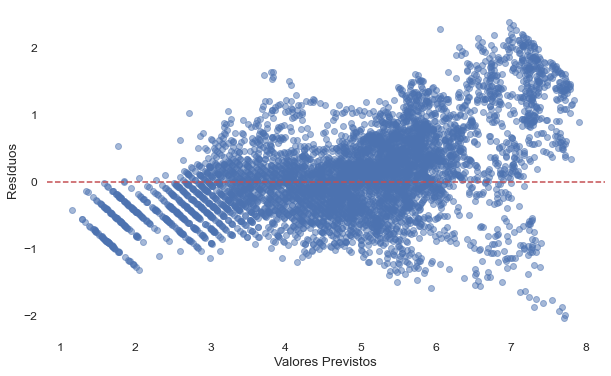

In [101]:
# Resíduos
residuos = y_test - y_pred

# Configurar as propriedades das fontes e estilo
sns.set(font='Arial', font_scale=1.1, style="white")

# Configurar tamanho da figura e eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o gráfico de dispersão
ax.scatter(y_pred, residuos, alpha=0.5)
ax.axhline(y=0, color='r', linestyle='--')

# Título e etiquetas dos eixos
ax.set_title('')
ax.set_xlabel('Valores Previstos')
ax.set_ylabel('Resíduos')

# Remover a grade, bordas e definir propriedades dos eixos
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', color='black', width=1.5)

# Remover a cor de fundo
ax.set_facecolor('none')
fig.set_facecolor('none')

plt.show()

In [91]:
import numpy as np
from scipy import stats

# Gere uma amostra de dados (substitua isso pelos seus dados)
# Exemplo: seus_dados = np.array([1.2, 2.3, 3.4, 3.8, 5.5, 6.7, 7.9, 8.1, 9.4, 10.1])
seus_dados = df['RUL']

# Normalizar os dados (se você estiver testando contra uma distribuição normal)
seus_dados_normalizados = (seus_dados - np.mean(seus_dados)) / np.std(seus_dados)

# Realizar o teste KS contra uma distribuição normal
ks_statistic, ks_p_value = stats.kstest(seus_dados_normalizados, 'norm')

# Exibir os resultados
print(f"Estatística KS: {ks_statistic}")
print(f"P-valor KS: {ks_p_value}")

# Interpretando o P-valor
if ks_p_value > 0.05:
    print("Não podemos rejeitar a hipótese nula. A amostra parece seguir uma distribuição normal.")
else:
    print("Rejeitamos a hipótese nula. A amostra não parece seguir uma distribuição normal.")

Estatística KS: 0.024734925216302495
P-valor KS: 2.4127918834233668e-15
Rejeitamos a hipótese nula. A amostra não parece seguir uma distribuição normal.


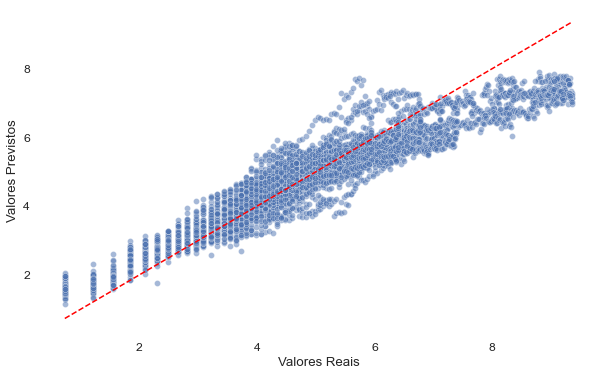

In [100]:
# Configurar as propriedades das fontes e estilo
sns.set(font='Arial', font_scale=1.1, style="white")

# Configurar tamanho da figura e eixo
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar o gráfico de dispersão (scatterplot)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=ax)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')

# Título e etiquetas dos eixos
ax.set_title('')
ax.set_xlabel('Valores Reais')
ax.set_ylabel('Valores Previstos')

# Remover a grade, bordas e definir propriedades dos eixos
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', color='black', width=1.5)

# Remover a cor de fundo
ax.set_facecolor('none')
fig.set_facecolor('none')

plt.show()

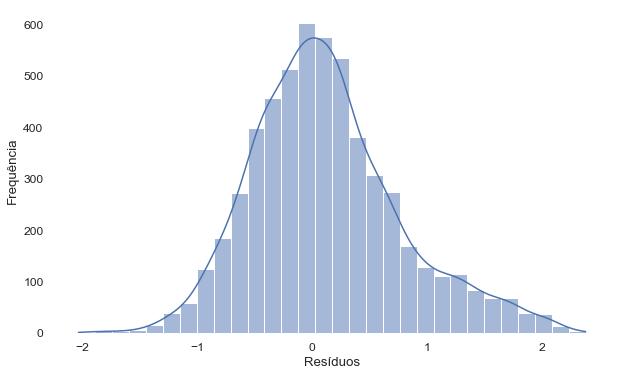

In [99]:

# Configurar as propriedades das fontes e estilo
sns.set(font='Arial', font_scale=1.1, style="white")

# Configurar tamanho da figura
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar a distribuição dos resíduos
sns.histplot(residuos, kde=True, bins=30, ax=ax)

# Título e etiquetas dos eixos
ax.set_title("")
ax.set_xlabel("Resíduos")
ax.set_ylabel("Frequência")

# Remover a grade, bordas e definir propriedades dos eixos
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='both', color='black', width=1.5)

# Remover a cor de fundo
ax.set_facecolor('none')
fig.set_facecolor('none')

plt.show()

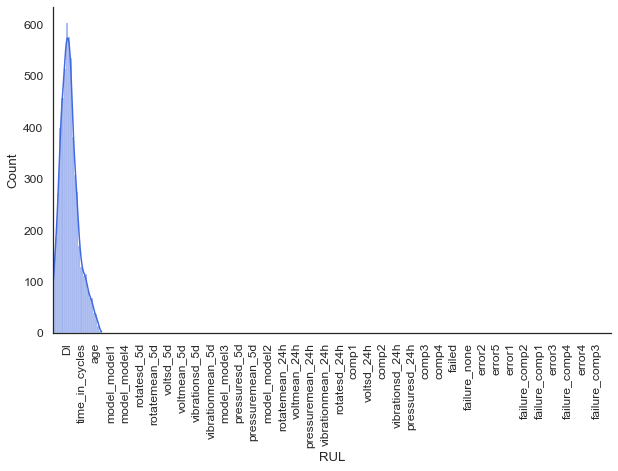

In [97]:
importances = random_search.best_estimator_.feature_importances_
feature_names = X_train.columns

# Organizando as importâncias em ordem decrescente
sorted_idx = importances.argsort()[::-1]

# Configurar a figura sem grade e borda
plt.figure(figsize=(10, 6))
plt.title("")
bars = plt.bar(range(X_train.shape[1]), importances[sorted_idx], align="center")

# Definir a mesma cor das barras do gráfico de resíduos
residuo_color = sns.histplot(residuos, kde=True, bins=30, color='royalblue').get_lines()[0].get_color()

# Aplicar a cor ao gráfico de importância das características
for bar in bars:
    bar.set_color(residuo_color)

plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlim([-1, X_train.shape[1]])

# Remover bordas dos eixos e fundo branco
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_facecolor('none')

plt.show()

In [95]:
residuos = residuos.drop(columns=['Unnamed: 0'])

In [102]:
df.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'time_in_cycles', 'voltmean_24h',
       'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h',
       'rotatesd_24h', 'pressuresd_24h', 'vibrationsd_24h', 'voltmean_5d',
       'rotatemean_5d', 'pressuremean_5d', 'vibrationmean_5d', 'voltsd_5d',
       'rotatesd_5d', 'pressuresd_5d', 'vibrationsd_5d', 'error1', 'error2',
       'error3', 'error4', 'error5', 'comp1', 'comp2', 'comp3', 'comp4', 'age',
       'DI', 'RULWeek', 'failed', 'RUL', 'RUL_I', 'model_model1',
       'model_model2', 'model_model3', 'model_model4', 'failure_comp1',
       'failure_comp2', 'failure_comp3', 'failure_comp4', 'failure_none'],
      dtype='object')